<a href="https://colab.research.google.com/github/Chanchal2411/AI-powered_River_Pollution_Monitoring/blob/main/AI_powered_River_Pollution_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load CSV Files

In [31]:
import pandas as pd

# Load CSVs
ganga_df = pd.read_csv("/content/ganga.csv")
sangam_df = pd.read_csv("/content/sangam.csv")

# Tag source
ganga_df['River'] = 'Ganga'
sangam_df['River'] = 'Sangam'

# Combine both
combined_df = pd.concat([ganga_df, sangam_df], ignore_index=True)

Load Yamuna JSON

In [32]:
import json

with open("/content/annotations.json", "r") as f:
    data = json.load(f)

pollution_data = []

for image_id, image_info in data.items():
    for region in image_info['regions']:
        label = region['region_attributes'].get('polluted')
        if label:
            pollution_data.append({
                'Image': image_info['filename'],
                'Polluted': label
            })

yamuna_df = pd.DataFrame(pollution_data)
yamuna_df['River'] = 'Yamuna'

Data Cleaning

In [33]:
# Drop rows with missing values
combined_df.dropna(inplace=True)

# Encode 'Status' as label
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
combined_df['Status_Label'] = le.fit_transform(combined_df['Status'])

ML Model Traning

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features and target
features = ['DO', 'pH', 'ORP', 'Cond', 'Temp', 'WQI']
X = combined_df[features]
y = combined_df['Status_Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

   Excellent       1.00      1.00      1.00       547
        Fair       1.00      1.00      1.00      7963
        Good       1.00      1.00      1.00      3320
        Poor       1.00      1.00      1.00      4449
   Very Poor       1.00      1.00      1.00      3500

    accuracy                           1.00     19779
   macro avg       1.00      1.00      1.00     19779
weighted avg       1.00      1.00      1.00     19779



Train and Saveing the Model

In [35]:
import joblib

# After training your RandomForestClassifier
joblib.dump(model, 'rf_model.pkl')

['rf_model.pkl']

Dashboard

<ipython-input-36-2168610107>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




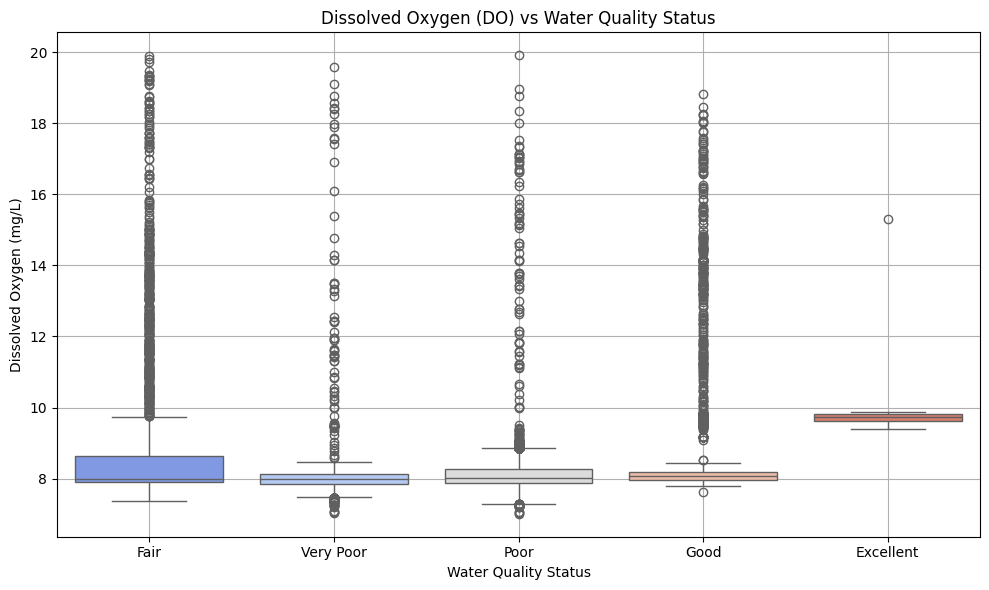

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: DO vs Status
plt.figure(figsize=(10,6))
sns.boxplot(data=combined_df, x='Status', y='DO', palette='coolwarm')
plt.title("Dissolved Oxygen (DO) vs Water Quality Status")
plt.xlabel("Water Quality Status")
plt.ylabel("Dissolved Oxygen (mg/L)")
plt.grid(True)
plt.tight_layout()
plt.savefig("DO_vs_water_quality_status.png", dpi=300)
plt.show()

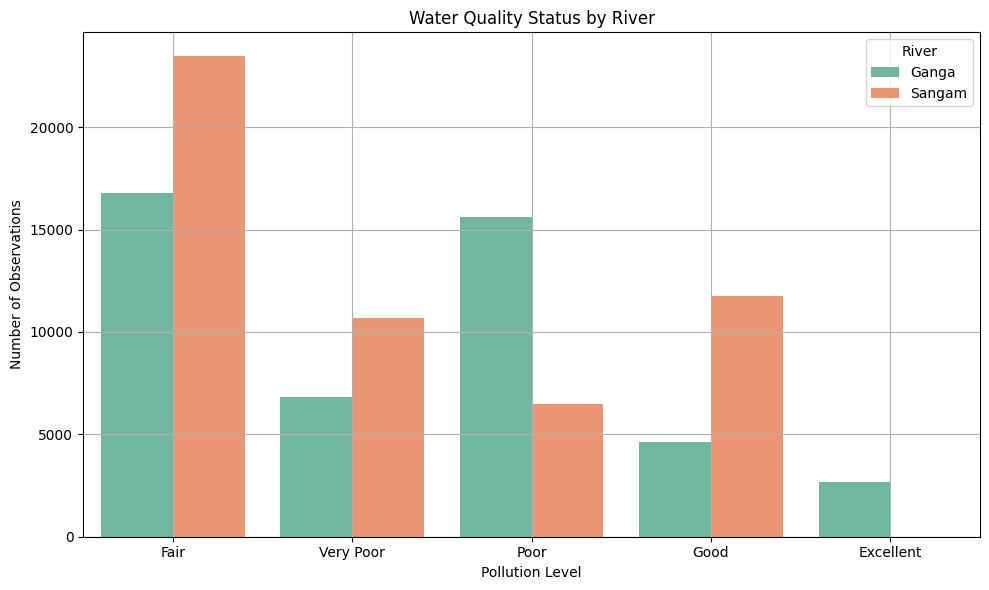

In [37]:
# Count of each status per river
plt.figure(figsize=(10,6))
sns.countplot(data=combined_df, x='Status', hue='River', palette='Set2')
plt.title("Water Quality Status by River")
plt.xlabel("Pollution Level")
plt.ylabel("Number of Observations")
plt.legend(title='River')
plt.grid(True)
plt.tight_layout()
plt.savefig("water_quality_status_river.png", dpi=300)
plt.show()

<Axes: title={'center': 'Yamuna Pollution Label Count'}, ylabel='Image Regions'>

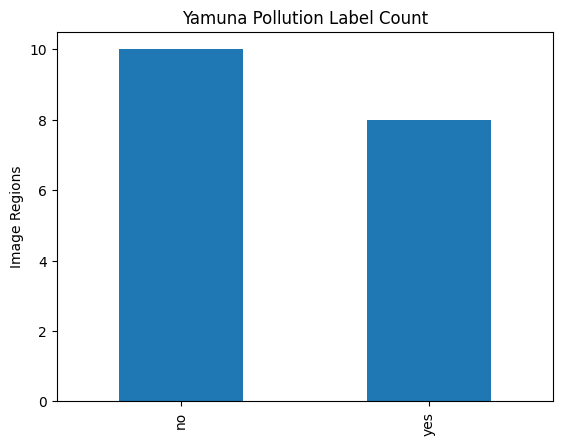

In [45]:
import json
import pandas as pd

with open("annotations.json") as f:
    yamuna_annotations = json.load(f)

pollution_labels = []

for img_id, details in yamuna_annotations.items():
    for region in details['regions']:
        status = region['region_attributes'].get('polluted')
        if status:
            pollution_labels.append(status)

# Count polluted vs not
pd.Series(pollution_labels).value_counts().plot(kind='bar', title="Yamuna Pollution Label Count", ylabel='Image Regions')

Save test predictions:

In [38]:
X_test['Predicted_Status'] = le.inverse_transform(model.predict(X_test))
X_test['Actual_Status'] = le.inverse_transform(y_test)
X_test.to_csv('river_pollution_predictions.csv', index=False)

In [39]:
import plotly.express as px

combined_df['Status'] = combined_df['Status'].astype(str)

fig = px.scatter(
    combined_df,
    x='DO',
    y='WQI',
    color='Status',
    size='Temp',
    hover_data=['River'],
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_layout(title='DO vs WQI (Bubble Size = Temp)')
fig.show()

Export plots as PNG

In [40]:
plt.savefig("do_vs_status.png", dpi=300)

<Figure size 640x480 with 0 Axes>

1. pH vs Status (boxplot)

<ipython-input-41-1371309282>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




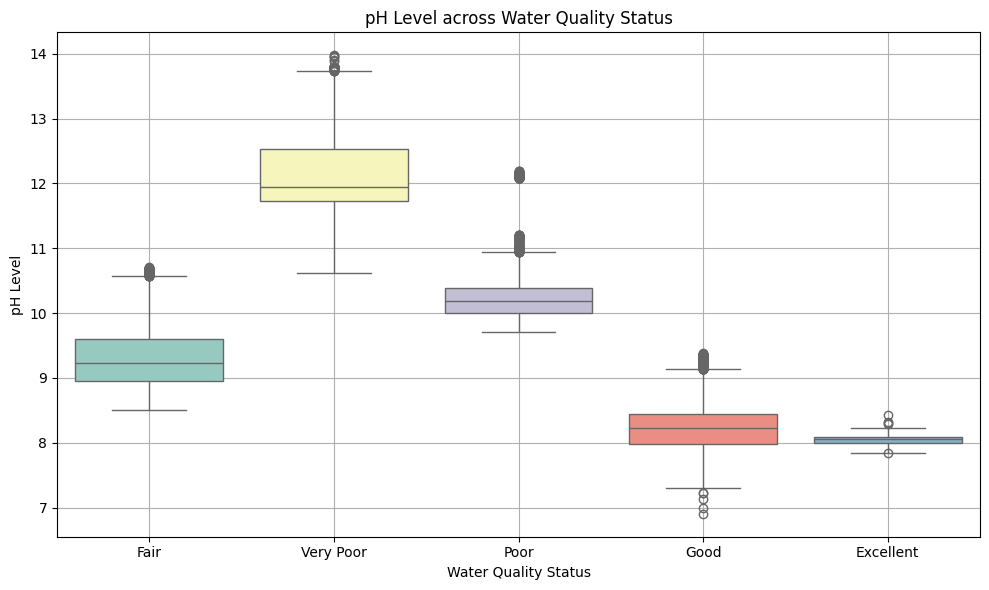

In [41]:
plt.figure(figsize=(10,6))
sns.boxplot(data=combined_df, x='Status', y='pH', palette='Set3')
plt.title("pH Level across Water Quality Status")
plt.xlabel("Water Quality Status")
plt.ylabel("pH Level")
plt.grid(True)
plt.tight_layout()
plt.savefig("ph_vs_status.png", dpi=300)
plt.show()

2. WQI vs Temperature (Scatter with Hue)

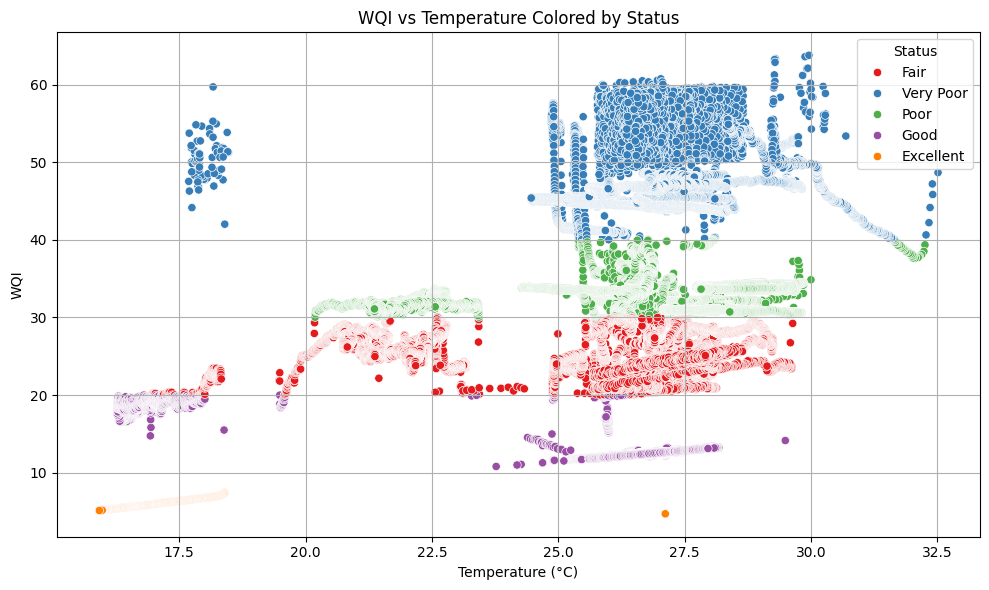

In [42]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=combined_df, x='Temp', y='WQI', hue='Status', palette='Set1')
plt.title("WQI vs Temperature Colored by Status")
plt.xlabel("Temperature (°C)")
plt.ylabel("WQI")
plt.grid(True)
plt.tight_layout()
plt.savefig("wqi_vs_temp.png", dpi=300)
plt.show()

3. ORP vs Conductivity (2D Scatter)

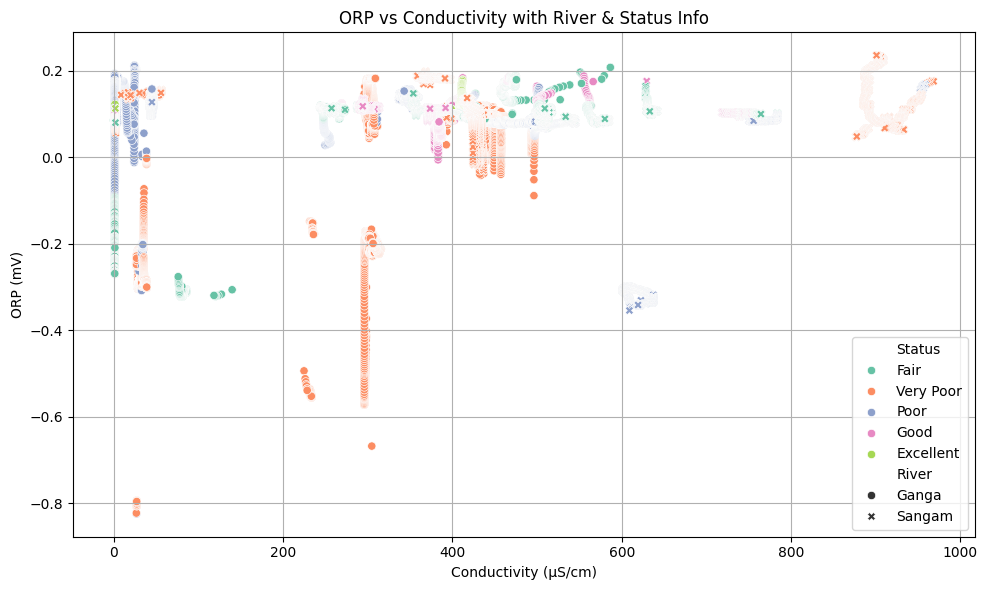

In [43]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=combined_df, x='Cond', y='ORP', hue='Status', style='River', palette='Set2')
plt.title("ORP vs Conductivity with River & Status Info")
plt.xlabel("Conductivity (µS/cm)")
plt.ylabel("ORP (mV)")
plt.grid(True)
plt.tight_layout()
plt.savefig("orp_vs_cond.png", dpi=300)
plt.show()

4. Average WQI per River (Bar Chart)

<ipython-input-44-342635349>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




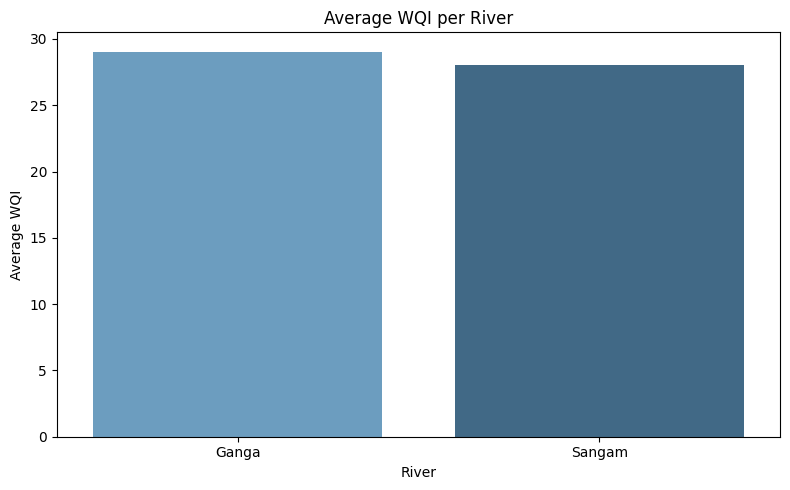

In [44]:
plt.figure(figsize=(8,5))
avg_wqi = combined_df.groupby('River')['WQI'].mean().reset_index()
sns.barplot(data=avg_wqi, x='River', y='WQI', palette='Blues_d')
plt.title("Average WQI per River")
plt.ylabel("Average WQI")
plt.xlabel("River")
plt.tight_layout()
plt.savefig("avg_wqi_per_river.png", dpi=300)
plt.show()